# Heart Failure Clinical Records Dataset - Lab 6

#### MinMax Normalization

In [10]:
import ds_functions as ds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, validation_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.metrics as metrics
from imblearn.over_sampling import SMOTE

data: pd.DataFrame = pd.read_csv('datasets/heart_failure_clinical_records_dataset.csv')
original_data = data.copy()
target = 'DEATH_EVENT'

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data)
df_nr = pd.DataFrame(transf.transform(data), columns= data.columns)
norm_data_minmax = df_nr


### Balancing

In [11]:
target_count = original_data[target].value_counts()
min_class = target_count.idxmin()
ind_min_class = target_count.index.get_loc(min_class)

RANDOM_STATE = 42
values = {'Original': [target_count.values[ind_min_class], target_count.values[1-ind_min_class]]}

df_class_min = original_data[original_data[target] == min_class]
df_class_max = original_data[original_data[target] != min_class]

df_under = df_class_max.sample(len(df_class_min))
values['UnderSample'] = [target_count.values[ind_min_class], len(df_under)]
df_over = df_class_min.sample(len(df_class_max), replace=True)
values['OverSample'] = [len(df_over), target_count.values[1-ind_min_class]]
smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
y = original_data.pop(target).values
X = original_data.values
smote_X, smote_y = smote.fit_sample(X, y)
smote_target_count = pd.Series(smote_y).value_counts()
values['SMOTE'] = [smote_target_count.values[ind_min_class], smote_target_count.values[1-ind_min_class]]

over_sampled = pd.concat([df_over, df_class_max])
under_sampled = pd.concat([df_under, df_class_min])

## Gradient Boosting

In [3]:
def gradient_boosting(X, y):
    print('{', len(X), ',', len(y), '}')
    trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

    n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
    max_depths = [5, 10, 25]
    learning_rate = [.1, .3, .5, .7, .9]
    best = ('', 0, 0)
    last_best = 0
    best_tree = None

    cols = len(max_depths)
    plt.figure()
    fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
    for k in range(len(max_depths)):
        d = max_depths[k]
        values = {}
        for lr in learning_rate:
            yvalues = []
            for n in n_estimators:
                gb = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
                gb.fit(trnX, trnY)
                prdY = gb.predict(tstX)
                yvalues.append(metrics.accuracy_score(tstY, prdY))
                if yvalues[-1] > last_best:
                    best = (d, lr, n)
                    last_best = yvalues[-1]
                    best_tree = gb
            values[lr] = yvalues
        ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Gradient Boorsting with max_depth=%d'%d,
                            xlabel='nr estimators', ylabel='accuracy', percentage=True)

    plt.show()
    print('Best results with depth=%d, learning rate=%1.2f and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

    prd_trn = best_tree.predict(trnX)
    prd_tst = best_tree.predict(tstX)
    ds.plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)


#### Unbalanced Classification

{ 299 , 299 }


<Figure size 600x450 with 0 Axes>

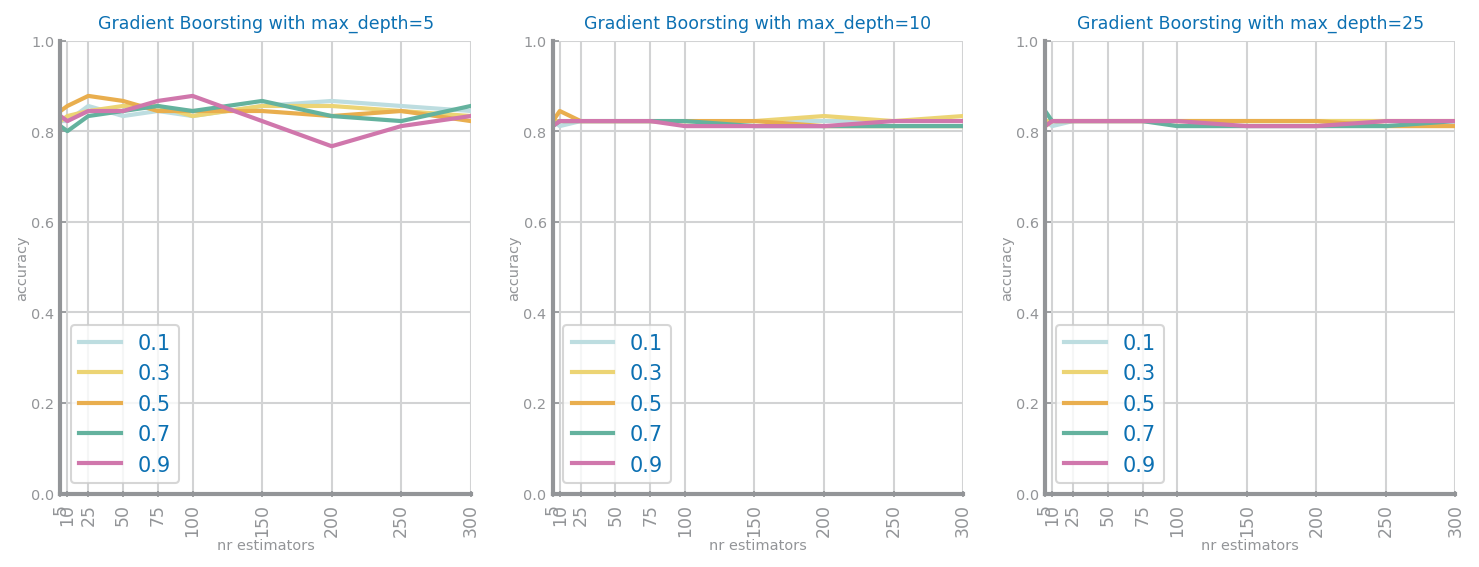

Best results with depth=5, learning rate=0.50 and 25 estimators, with accuracy=0.88
Confusion Matrix Test
TruePositives:  21
FalsePositives:  3
TrueNegatives:  58
FalseNegatives:  8


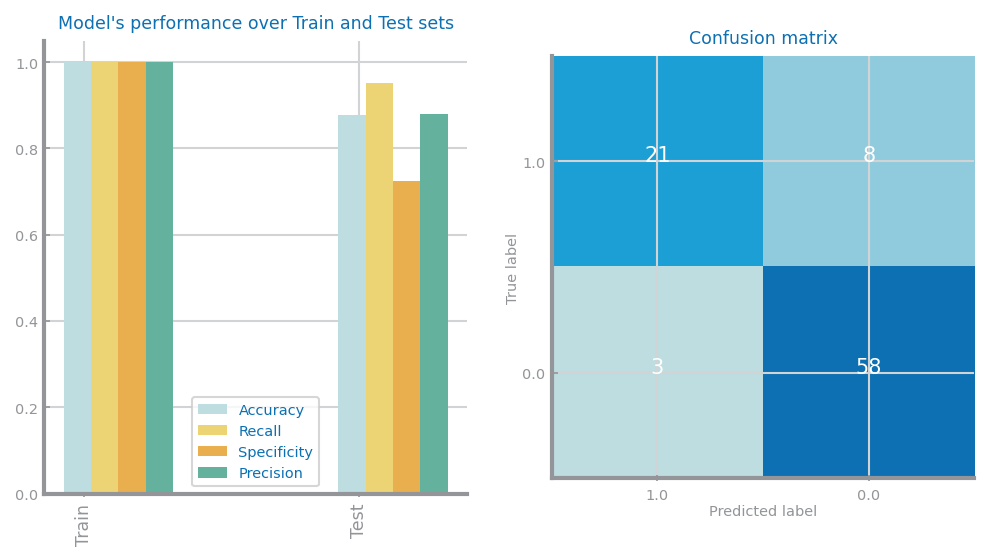

In [4]:
y: np.ndarray = norm_data_minmax.pop(target).values
X: np.ndarray = norm_data_minmax.values
labels = pd.unique(y)
gradient_boosting(X, y)

#### Over Sampled Classification

{ 406 , 406 }


<Figure size 600x450 with 0 Axes>

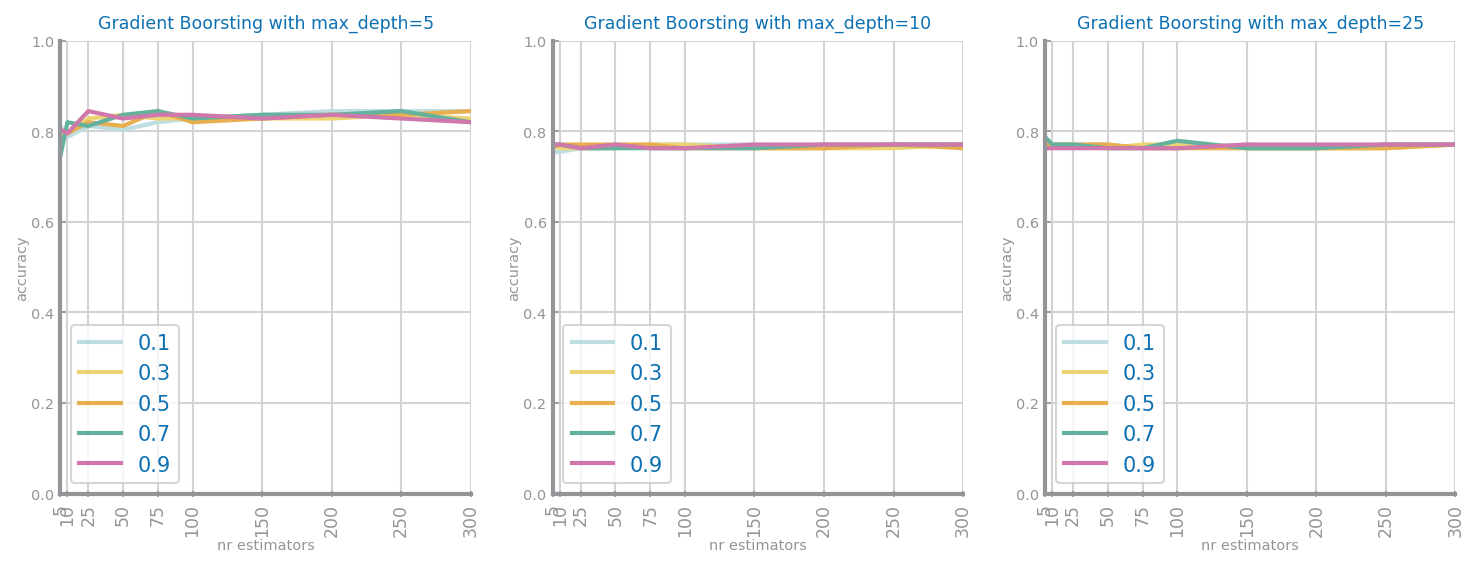

Best results with depth=5, learning rate=0.10 and 200 estimators, with accuracy=0.84
Confusion Matrix Test
TruePositives:  47
FalsePositives:  5
TrueNegatives:  56
FalseNegatives:  14


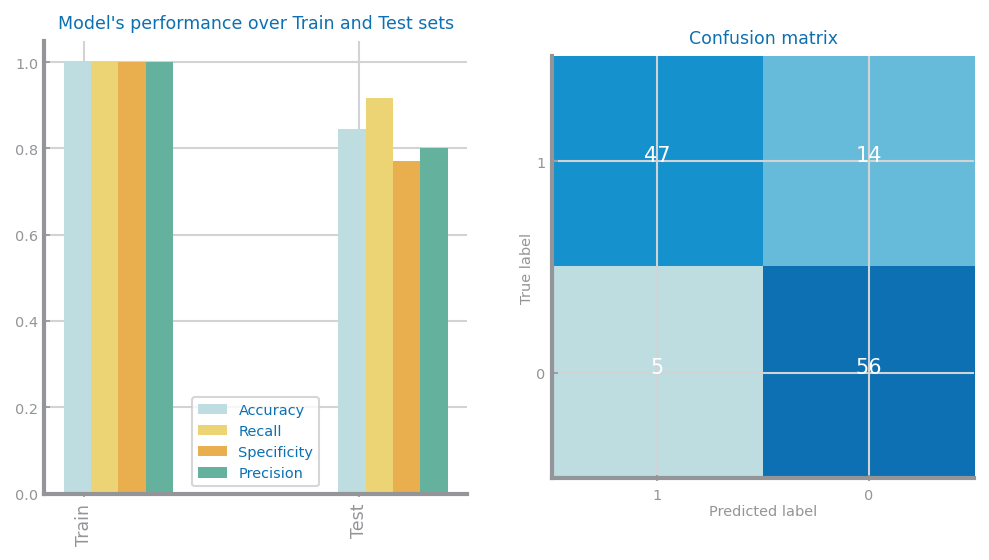

In [5]:
y: np.ndarray = over_sampled.pop(target).values
X: np.ndarray = over_sampled.values
labels: np.ndarray = pd.unique(y)
gradient_boosting(X, y)


#### Under Sampled Classification

{ 192 , 192 }


<Figure size 600x450 with 0 Axes>

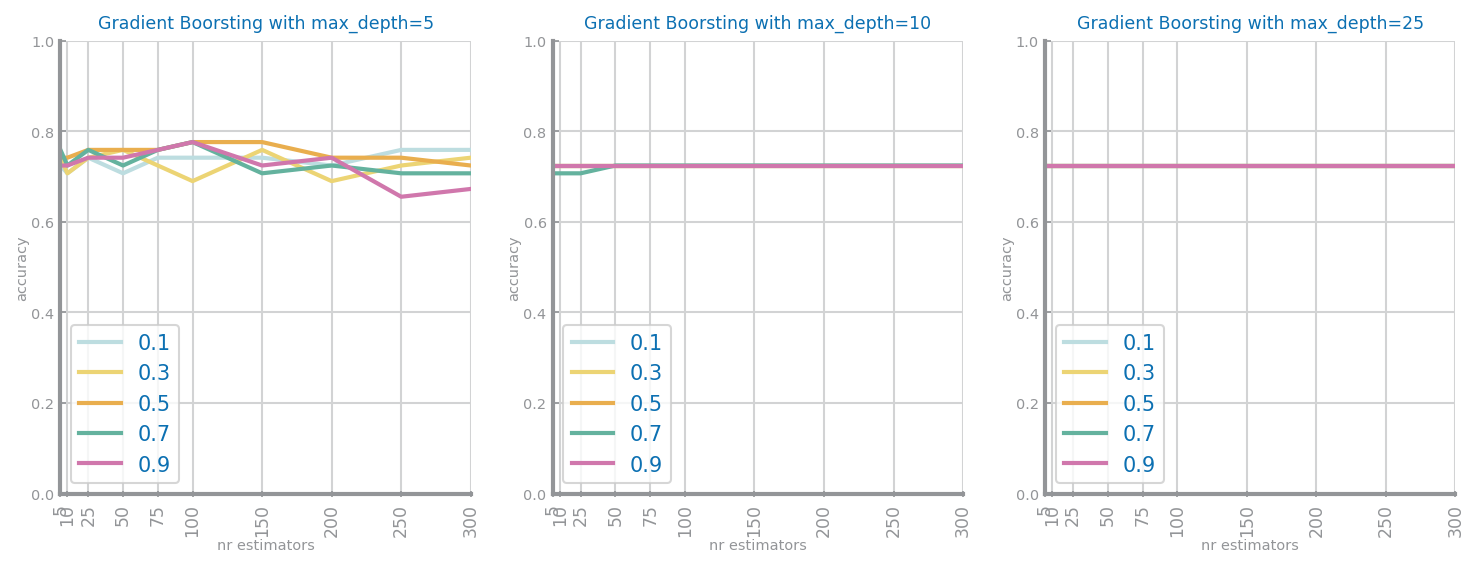

Best results with depth=5, learning rate=0.50 and 100 estimators, with accuracy=0.78
Confusion Matrix Test
TruePositives:  22
FalsePositives:  6
TrueNegatives:  23
FalseNegatives:  7


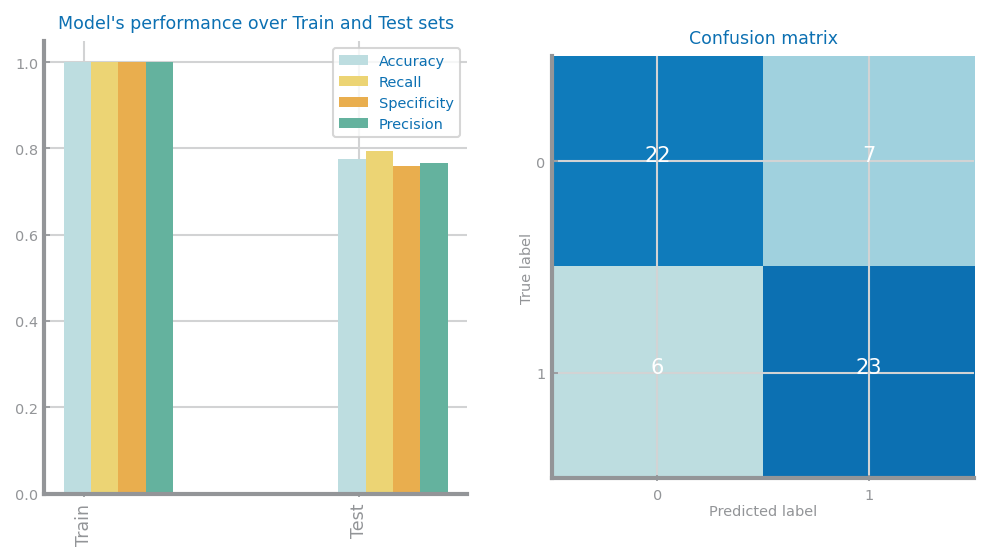

In [12]:
y: np.ndarray = under_sampled.pop(target).values
X: np.ndarray = under_sampled.values
labels: np.ndarray = pd.unique(y)
gradient_boosting(X, y)

#### SMOTE classification

{ 406 , 406 }


<Figure size 600x450 with 0 Axes>

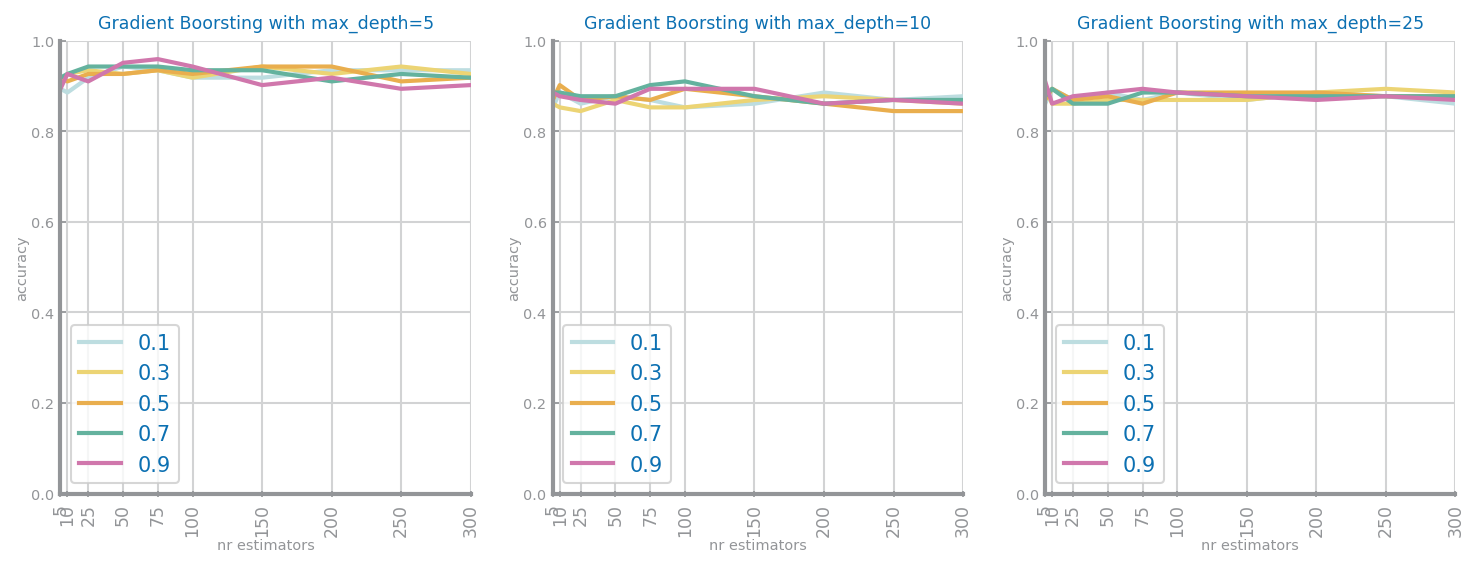

Best results with depth=5, learning rate=0.90 and 75 estimators, with accuracy=0.96
Confusion Matrix Test
TruePositives:  59
FalsePositives:  3
TrueNegatives:  58
FalseNegatives:  2


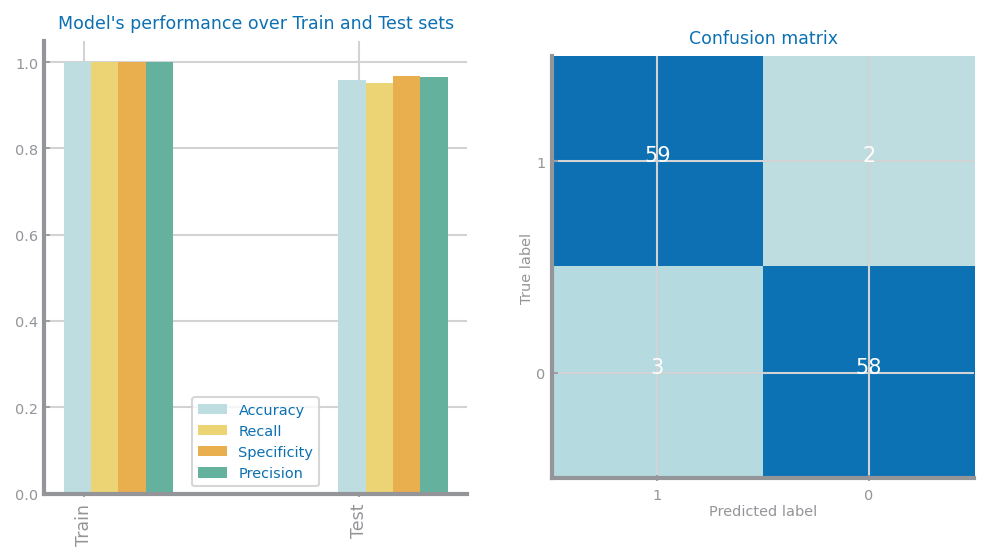

In [7]:
y = smote_y
X = smote_X
labels = pd.unique(y)
gradient_boosting(X, y)